In [1]:
# # Install dependencies
# !pip install nltk sklearn PyStemmer tqdm

In [20]:
import json

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

import re
import nltk
import pickle as pkl
import numpy as np
from tqdm import tqdm
import scipy.sparse as sp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
import Stemmer

def tokenizer_word(string):
    string = string.lower()
    tokens = [w for w in re.split("[\W,_]+", string) if ((w != "") and (w not in STOPWORDS))]
    tokens = stemmer.stemWords(tokens)
    return tokens

stemmer = Stemmer.Stemmer('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/stefanus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
def read_sparse_mat(filename):
    with open(filename) as f:
        nr, nc = map(int, f.readline().split(' '))
        data = []; inds = []; indptr = [0]
        for line in tqdm(f, total=nr):
            row = list(map(lambda x: x.split(':'), line.split()))
            inds.append(np.array(list(map(lambda x: int(x[0]), row))))
            data.append(np.array(list(map(lambda x: float(x[1]), row))))
            indptr.append(indptr[-1]+len(row))
        spmat = sp.csr_matrix((np.concatenate(data), np.concatenate(inds), indptr), (nr, nc))
        return spmat

In [22]:
# For bigger datasets (amazon-1m, wikipedia-1m) use larger MAX_FEATURES (500000/1000000 used in zestxml paper)
MAX_FEATURES=50000

## Visualize

In [23]:
def get_text(x, text, X_Xf, sep=' ', K=-1, attr='bold underline'):
    if K == -1: K = X_Xf[x].nnz
    sorted_inds = X_Xf[x].indices[np.argsort(-X_Xf[x].data)][:K]
    #print(sorted_inds)
    return '%d : \n'%x + sep.join(['%s(%.2f, %d)'%(_c(text[i], attr=attr), X_Xf[x, i], i) for i in sorted_inds])

In [24]:
class bcolors:
    purple = '\033[95m'
    blue = '\033[94m'
    green = '\033[92m'
    warn = '\033[93m' # dark yellow
    fail = '\033[91m' # dark red
    white = '\033[37m'
    yellow = '\033[33m'
    red = '\033[31m'
    
    ENDC = '\033[0m'
    bold = '\033[1m'
    underline = '\033[4m'
    reverse = '\033[7m'
    
    on_grey = '\033[40m'
    on_yellow = '\033[43m'
    on_red = '\033[41m'
    on_blue = '\033[44m'
    on_green = '\033[42m'

def _c(*args, attr='bold'):
    string = ''.join([bcolors.__dict__[a] for a in attr.split()])
    string += ' '.join([str(arg) for arg in args])
    return string

In [6]:
orig_Xf = [x.strip() for x in open(f'dataset/zero_shot_dataset_combined/zestxml/Xf.txt')]
orig_trn_X_Xf = read_sparse_mat(f'dataset/zero_shot_dataset_combined/zestxml/trn_X_Xf.txt')
orig_tst_X_Xf = read_sparse_mat(f'dataset/zero_shot_dataset_combined/zestxml/tst_X_Xf.txt')

orig_Yf = [x.strip() for x in open(f'dataset/zero_shot_dataset_combined/zestxml/Yf.txt')]
orig_Y_Yf = read_sparse_mat(f'dataset/zero_shot_dataset_combined/zestxml/Y_Yf.txt')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37161/37161 [00:00<00:00, 266365.89it/s]


100%|██████████████████████████████████████████████████████████| 37161/37161 [00:00<00:00, 123240.44it/s]


In [26]:
print(get_text(0, orig_Xf, orig_tst_X_Xf))

0 : 
react native(0.26, 4685931) native(0.24, 3825404) react(0.24, 4684606) kit web(0.11, 3225861) boilerplate(0.11, 979796) starter kit(0.11, 5385850) npx react(0.10, 3956239) react starter(0.10, 4686509) simulator(0.10, 5215230) bash start(0.09, 872348) splash screen(0.09, 5337611) redux(0.09, 4734902) native run(0.09, 3827396) starter(0.09, 5385633) kit(0.09, 3225248) native mobile(0.09, 3826902) ios simulator(0.09, 3047254) ios(0.08, 3045415) splash(0.08, 5337487) for native(0.08, 2361047) start in(0.08, 5381751) android(0.07, 612817) flux(0.07, 2330001) rocket(0.07, 4897620) linting(0.07, 3392313) npx(0.07, 3956051) the react(0.07, 5697288) kit expo(0.06, 3225450) boilerplate builder(0.06, 979868) boilerplate previous(0.06, 980136) firebase intro(0.06, 2293687) consultation get(0.06, 1452289) some consultation(0.06, 5285196) opinions tests(0.06, 4106739) strategies splash(0.06, 5431687) matt mcnamee(0.06, 3573642) screen assets(0.06, 5019271) organise quote(0.06, 4147343) simulato

In [9]:
print(get_text(21359, orig_Yf, orig_Y_Yf))

21359 : 
__label__21359__powder(0.72, 13016) powder(0.69, 64302)


In [27]:
def get_scores(x, text, X_Xf, sep=' ', K=-1, attr='bold underline'):
    if K == -1: K = X_Xf[x].nnz
    sorted_inds = X_Xf[x].indices[np.argsort(-X_Xf[x].data)][:K]
    result = dict()
    for i in sorted_inds:
        result[text[i]] = X_Xf[x, i]
        #print(result)
    return result

In [28]:
X_scores = get_scores(0, orig_Xf, orig_tst_X_Xf)
Y_scores = get_scores(21359, orig_Yf, orig_Y_Yf)

In [29]:
def combine_scores(x_scores, y_scores, combination):
    new_scores = x_scores.copy()
    for i in y_scores:
        if i in x_scores:
            #print(x_scores[i])
            #print(y_scores[i])
            if combination == "+":
                new_scores[i] = (x_scores[i] + y_scores[i])
            else:
                new_scores[i] = (x_scores[i] * y_scores[i])
    return new_scores

In [30]:
new_s = combine_scores(X_scores,Y_scores,"+")
# print(new_s)

In [31]:


#text = "react native app what is this usage docs need help looking for something else react native starter kit expo boilerplate react starter kit web boilerplate previous version react starter kit web native w firebase intro this project was bootstrapped with the react boilerplate builder by matt mcnamee the project is super helpful to kick start your next project as it provides a lot of the common tools you may reach for all ready to go specifically flux architecture redux redux wrapper rematch routing and navigation react native router flux for native mobile navigation data caching offline redux persist ui toolkit s native base for native mobile code linting with airbnb s js linting guidelines deployment strategy both manual and automated strategies splash screen assets react native splash screen getting started install react native debugger and open before running the application install eslint prettier and editor configuration plugins into your ide ensure your machine has the react native dependencies installed bash install dependencies yarn install cd ios pod install ios bash start in the ios simulator npx react native run ios simulator iphone 11 android bash start in the android simulator note open android studio tools avd run a device example device specs d5da npx react native run android docs contributing to this project faqs opinions tests testing understanding the file structure deploy the application further help this repo is a great place to start but if you d prefer to sit back and have your new project built for you or just need some consultation get in touch with me directly and i can organise a quote rocket a react native boilerplate application to get you up and running very very quickly rocket"
text = "react native app what is this usage docs need help looking for something else react native starter kit expo boilerplate react starter kit web boilerplate previous version react starter kit web native w firebase intro this project was bootstrapped with the react boilerplate builder by matt mcnamee the project is super helpful to kick start your next project as it provides a lot of the common tools you may reach for all ready to go"
unigram_text = text.split(" ")
score_text = []
for i in range(len(unigram_text)):
    score_text.append(0)
span = 2
words = text.split(" ")
bigram_text = [" ".join(words[i:i+span]) for i in range(0, len(words), span)]
temp = {k: v for k, v in sorted(new_s.items(), key=lambda item: item[1], reverse=True)}
number = 0
for i in temp:
    if number < 20:
        if i in temp:
            if " " in i:
                list_index = [m.start() for m in re.finditer(i, text)]
                for j in list_index:
                    number_of_string = text[:j].count(' ')
                    if score_text[number_of_string] < temp[i]:
                        score_text[number_of_string] = temp[i]
                    if score_text[number_of_string+1] < temp[i]:
                        score_text[number_of_string+1] = temp[i]
            else:
                indices = [k for k, x in enumerate(unigram_text) if x == i]
                for j in indices:
                    if score_text[j] < temp[i]:
                        score_text[j] = temp[i]
    number+=1
print(unigram_text)
print(score_text)
            

['react', 'native', 'app', 'what', 'is', 'this', 'usage', 'docs', 'need', 'help', 'looking', 'for', 'something', 'else', 'react', 'native', 'starter', 'kit', 'expo', 'boilerplate', 'react', 'starter', 'kit', 'web', 'boilerplate', 'previous', 'version', 'react', 'starter', 'kit', 'web', 'native', 'w', 'firebase', 'intro', 'this', 'project', 'was', 'bootstrapped', 'with', 'the', 'react', 'boilerplate', 'builder', 'by', 'matt', 'mcnamee', 'the', 'project', 'is', 'super', 'helpful', 'to', 'kick', 'start', 'your', 'next', 'project', 'as', 'it', 'provides', 'a', 'lot', 'of', 'the', 'common', 'tools', 'you', 'may', 'reach', 'for', 'all', 'ready', 'to', 'go']
[0.2565506793814921, 0.2565506793814921, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2565506793814921, 0.2565506793814921, 0.1113070339632762, 0.1113070339632762, 0, 0.1137303691616832, 0.2358094517116998, 0.1113070339632762, 0.1141891793400286, 0.1141891793400286, 0.1137303691616832, 0, 0, 0.2358094517116998, 0.1113070339632762, 0.114189179340

Recomendation Topic 1: react-native


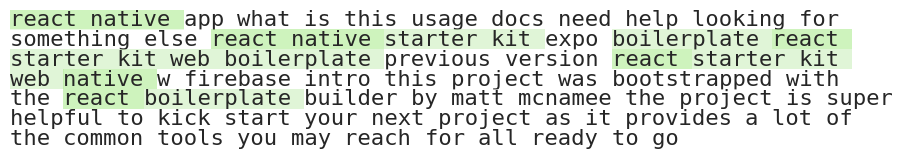

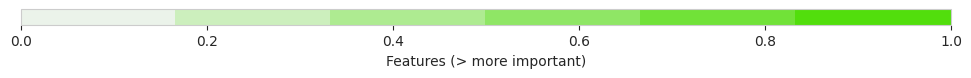

In [32]:
from numpy import linspace
import pylighter as pl
import numpy
import importlib
importlib.reload(pl)
%matplotlib inline
print("Recomendation Topic 1: react-native")
fig, ax = pl.render(unigram_text, numpy.array(score_text), sigma=1,filesave="foo0.png")
#plt.savefig('foo.png')
#fig, (ax1) = plt.subplots(1, 1, figsize=(10, 0.2))
#plt.colorbar(ScalarMappable(cmap=ListedColormap(sns.color_palette("light:#52DE0C"))), label='Features (> more important)', orientation='horizontal', cax=ax1) 


In [33]:
import os
import sys
import numpy as np
import scipy.sparse as sp
from scipy.sparse import csr_matrix
import pandas as pd
from io import StringIO
from tqdm import tqdm
from utils import *

def _filter(score_mat, filter_mat, copy=True):
    if filter_mat is None:
        return score_mat
    if copy:
        score_mat = score_mat.copy()

    temp = filter_mat.tocoo()
    score_mat[temp.row, temp.col] = 0
    del temp
    score_mat = score_mat.tocsr()
    score_mat.eliminate_zeros()
    return score_mat

In [34]:
dataset = 'topic_recommendation'
dataset_path = '/dataset/zero_shot_dataset_combined/zestxml/'
RES_DIR = f'{dataset_path}/Results/{dataset}'
# DATA_DIR = f'GZXML-Datasets/{dataset}'
DATA_DIR = f'{dataset_path}'

f = open("id_topics.textile", "r")
id_labels = f.readlines()
f.close()

score_mat = _filter(read_bin_spmat(f'{RES_DIR}/score_mat.bin').copy(), None)
# Shape should be:
# nrows = number of test data
# ncols = scores for possible labels
x = score_mat.toarray()
pred = []
for i, rows in enumerate(x):
    predictions = np.argpartition(rows, -10)[-10:]
    if i == 4225:
        print(predictions)
    predictions = predictions[::-1]
    if i == 4225:
        print(predictions)
    temp_pred = rows[predictions[:10]]
    if i == 4225:
        print(temp_pred)
    
    new_sort = np.argsort(temp_pred)
    if i == 4225:
        print(temp_pred)
    ns = list(new_sort)
    if i == 4255:
        print(ns)
    pred_list = []
    for kk in range(len(ns)):
        pred_list.append(predictions[ns[kk]])
    pred.append(pred_list)
    if i == 4225:
        print(pred_list)
        for k_test in pred_list:
            print(k_test)
            print(id_labels[k_test])

loaded bin file in buffer
[37070 30128 10773 25341 34511  9781 19936 25897  8130 13874]
[13874  8130 25897 19936  9781 34511 25341 10773 30128 37070]
[0.0325385  0.09172671 0.06146483 0.07197531 0.03416103 0.03142773
 0.02786249 0.02711094 0.02708924 0.02702442]
[0.0325385  0.09172671 0.06146483 0.07197531 0.03416103 0.03142773
 0.02786249 0.02711094 0.02708924 0.02702442]
[37070, 30128, 10773, 25341, 34511, 13874, 9781, 25897, 19936, 8130]
37070
rust-programming-language

30128
music-programming-language

10773
javascript-programming-language

25341
functional-programming

34511
neovim

13874
pillow-python

9781
programming-language

25897
hacktoberfest

19936
racket-lang

8130
racket



In [35]:
f = open("id_test_text.txt", "r")
text_test = f.readlines()
f.close()

f = open("id_topics.textile", "r")
id_labels = f.readlines()
f.close()

In [36]:
print(orig_tst_X_Xf.shape[0])
print(pred)
for i in range(1,5):
# for i in range(orig_tst_X_Xf.shape[0]):
    X_scores = get_scores(i, orig_Xf, orig_tst_X_Xf)
    print(X_scores)
    text = text_test[i].strip() 
    kk = 1
    print(i)
    #print(text)
    for j in [9]:
        print(pred[i])
#     for j in range(len(pred[i])):
        #print(j)
        #print(pred[i][j])
        Y_scores = get_scores(pred[i][j], orig_Yf, orig_Y_Yf)
        print(Y_scores)
        print(id_labels[pred[i][j]])
        #print("Recomendation Topic "+str(kk)+": "+str(id_labels[pred[i][j]]))
        unigram_text = text.split(" ")
        score_text = []
        for nn in range(len(unigram_text)):
            score_text.append(0)
        new_s = combine_scores(X_scores,Y_scores,"+")
        temp = {k: v for k, v in sorted(new_s.items(), key=lambda item: item[1], reverse=True)}
        number = 0
        for ii in temp:
            if number <= 20:
                if ii in temp:
                    if " " in ii:
                        list_index = [m.start() for m in re.finditer(ii, text)]
                        for jj in list_index:
                            number_of_string = text[:jj].count(' ')
                            if score_text[number_of_string] < temp[ii]:
                                score_text[number_of_string] = temp[ii]
                            if score_text[number_of_string+1] < temp[ii]:
                                score_text[number_of_string+1] = temp[ii]
                    else:
                        indices = [k for k, x in enumerate(unigram_text) if x == ii]
                        for jj in indices:
                            if score_text[jj] < temp[ii]:
                                score_text[jj] = temp[ii]
            number+=1
        #print("explanations/test-"+str(i)+"_prediction-"+str(kk)+"_"+str(id_labels[pred[i][j]]))
        fig, ax = pl.render(unigram_text, numpy.array(score_text), sigma=1, filesave="explanations/test-"+str(i)+"_prediction-"+str(kk)+"_"+str(id_labels[pred[i][j]]).strip()+".png")
        kk+=1

4255
[[16244, 21984, 6382, 16398, 29079, 11840, 36680, 28310, 5548, 18401], [1411, 18375, 30698, 27972, 9961, 18401, 25897, 614, 8021, 8051], [33076, 13803, 15183, 191, 8021, 21295, 16949, 31782, 8051, 20313], [10703, 29979, 952, 31604, 25897, 34985, 15500, 24990, 8051, 17288], [19655, 18171, 35288, 25860, 35161, 13640, 32497, 8051, 32794, 29165], [16666, 31877, 23291, 24990, 23362, 25639, 7005, 18884, 8051, 18401], [5943, 24296, 24775, 7961, 18815, 25897, 16385, 4108, 8021, 8051], [16233, 27323, 25156, 28507, 25897, 1079, 25401, 30822, 15111, 29464], [36345, 24158, 17491, 28071, 1527, 6700, 20107, 5716, 12475, 7697], [18916, 25897, 8799, 27213, 499, 16740, 35417, 16165, 34589, 1821], [30248, 4136, 26579, 13113, 33325, 8051, 4903, 20313, 29165, 28229], [19668, 33971, 25786, 33248, 4162, 25897, 29165, 8051, 7102, 23804], [3981, 36370, 5425, 4890, 33970, 369, 25897, 29165, 32497, 13874], [31019, 18364, 9302, 22084, 22229, 36257, 11770, 32902, 3307, 15265], [28191, 32567, 6815, 11619, 184